# Crime rate around Buenos Aires city's nightclubs

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [23]:
import statsmodels.api as sm
import statsmodels.formula.api as smf 

## Load city data

On the side-notebooks located on the `snb` folder, we divided all the area of Buenos Aires City in 3520 square areas. The information related to the crime rate and neighborhood name is inside the `city.csv` database. A binary categorical variable in the `club` column was used to signal if the square is inside a nightclub's area of influence.

Using the `cens` variable we excluded those square areas with a crime count of zero accounting for those areas not crossed by streets, since the geografical location of a crime is reported over the street address were it happed. An area not being crossed by any streets may be due to the areas being inside large parks, cementries, buildings, etc.

In [3]:
city = pd.read_csv('data/city.csv')

In [29]:
city = city.loc[city.cens == 0]

## Modeling

### Unadjusted effect of nighclubs on the crime rate on each square

By fitting a generalized linear model with a negative binomial distribution accounting for overdispersion, we regressed the effect of a square being inside a nightclub's area of influence on the crime count seeing inside that square.

In [16]:
model = smf.glm("mugs ~ club", data=city, family=sm.families.NegativeBinomial()).fit()

In [18]:
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   mugs   No. Observations:                 2772
Model:                            GLM   Df Residuals:                     2770
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7444.7
Date:                Thu, 03 Jan 2019   Deviance:                       1374.6
Time:                        02:21:00   Pearson chi2:                 1.89e+03
No. Iterations:                     5   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.3405      0.027     50.192      0.000       1.288       1.393
club           0.6774      0.043     15.781      0.0

In [35]:
np.exp(0.6774)

1.968752316054994

#### Interpretation

Squares surrounding nightclub have a crime count 1.96 (0.59-0.76) times higher than those squares not in the nightclub's vicinity.

### Adjusted by neighborhood

Neighborhood differ from each other by demography, economical activity, security, culture and other variables influencing crime rates. For this reason, adjusting by neighborhood will unconfound the mean effect of nightclubs.

In [31]:
model = smf.glm("mugs ~ club + C(hood)", data=city, family=sm.families.NegativeBinomial()).fit()

In [32]:
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   mugs   No. Observations:                 2772
Model:                            GLM   Df Residuals:                     2723
Model Family:        NegativeBinomial   Df Model:                           48
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7298.4
Date:                Thu, 03 Jan 2019   Deviance:                       1082.1
Time:                        02:39:49   Pearson chi2:                 1.28e+03
No. Iterations:                     6   Covariance Type:             nonrobust
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.7492      0.274      2.730      0.006       0.211       1.28

#### Interpretation

When adjusted by neighborhood, squares surrounding nightclubs showed a crime count 1.35 (0.18 - 0.41) times higher that those squares not surrounding it. By analyzing each level on the categorical variable `neighborhood`, we found that those with crime counts 2 times the mean are Constitucion, Balvanera, San Nicolas, San Cristobal, San Telmo, Almagro, Monserrat and Palermo.

## But why do nightclubs have this effect on crime count?

Nightclubs are a great surrogate variable for:

1. **Proximity to downtown**: Downtowns tend to have a bigger crime rate than the periphery of a city and nightlife businesses are more abundant on those parts.
2. **Nightclubs location**: Nightclubs are surrounded by nightlife businesses such as bars. The combination of young people, night, drugs and alcohol make places surrounding nightclubs more appealing to thefts and criminals looking for easy targets.
3. **Population displacement**: More people tend to gather arroud nightclubs areas during the night and early mornings on fridays and saturdays.

## Appendix: Figures

In [7]:
import geopandas as gpd
from shapely import wkt
from shapely.ops import cascaded_union

In [3]:
city = pd.read_csv('data/city.csv')

In [4]:
club = pd.read_csv('data/clubs.csv')

In [5]:
hood = pd.read_csv('data/original/hoods.csv')

In [8]:
area = cascaded_union(list(map(lambda x: x.buffer(0.009), club.geometry.map(wkt.loads))))

In [9]:
city.loc[:, 'geometry'] = city.geometry.map(wkt.loads)
club.loc[:, 'geometry'] = club.geometry.map(wkt.loads)

In [11]:
geohood = gpd.GeoDataFrame(hood.assign(group=1, geometry = hood.WKT.map(wkt.loads))).dissolve(by='group')

In [12]:
geoarea = gpd.GeoDataFrame({'geometry': area})

In [16]:
geoclub = gpd.GeoDataFrame(club)
geocity = gpd.GeoDataFrame(city)

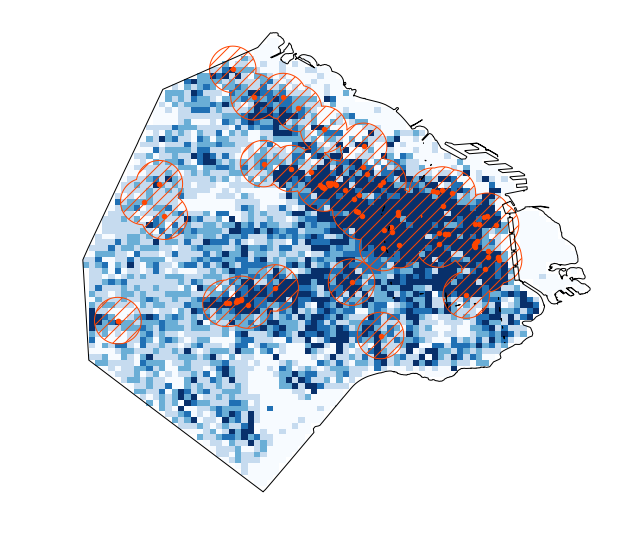

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
geocity.plot(column='mugs', cmap='Blues', scheme='quantiles', ax=ax)
geoclub.plot(color='orangered', markersize=20, ax=ax)
geoarea.plot(color='None', edgecolor='orangered', hatch='//', ax=ax)
geohood.plot(color='None', edgecolor='black', ax=ax)
plt.axis('off')
plt.savefig('./assets/figure1.svg')
plt.show()

In [27]:
len(city)

3520

In [26]:
club.loc[0, 'geometry'].buffer(0.009).bounds

(-58.40275, -34.614027, -58.38475, -34.596027)

In [ ]:
(-58.46033253706004,-34.53198487562864,
 -58.46033253706004,-34.52976297486542,